In [ ]:
# Install used packages if needed
!pip install opencv-python
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install lightgbm
!pip install matplotlib

In [2]:
import time
start_time = time.time()

In [ ]:
import os
import cv2
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import lightgbm as lgb
import matplotlib.pyplot as plt

In [ ]:
base_path = Path.cwd()
cell_types = ["im_Dyskeratotic", "im_Koilocytotic", "im_Metaplastic", "im_Parabasal", "im_Superficial-Intermediate"]

features = []
labels = []

In [5]:
for cell_type in cell_types:
    folder_path = os.path.join(base_path, cell_type, "CROPPED")

    for img_name in os.listdir(folder_path):
        if img_name.endswith((".bmp")):
            img_path = os.path.join(folder_path, img_name)

            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (128, 128))
            
            img_flat = img.flatten()

            features.append(img_flat)
            labels.append(cell_type)

In [6]:
features = np.array(features)
labels = np.array(labels)

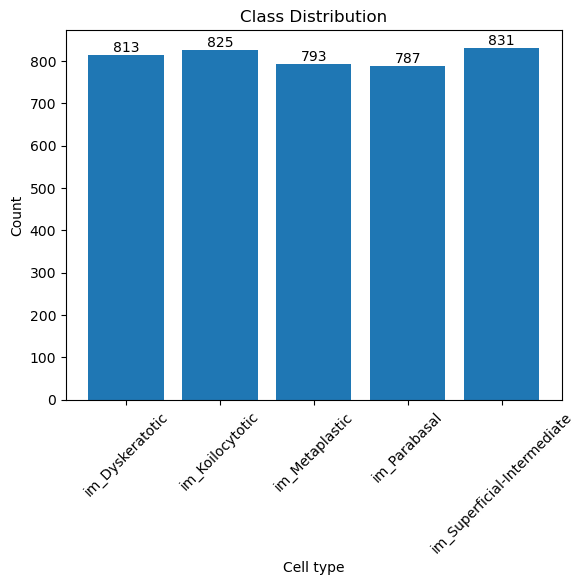

In [7]:
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("Cell type")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=45)

for i, count in enumerate(counts):
    plt.text(i, count+1, str(count), ha="center", va="bottom")

plt.show()

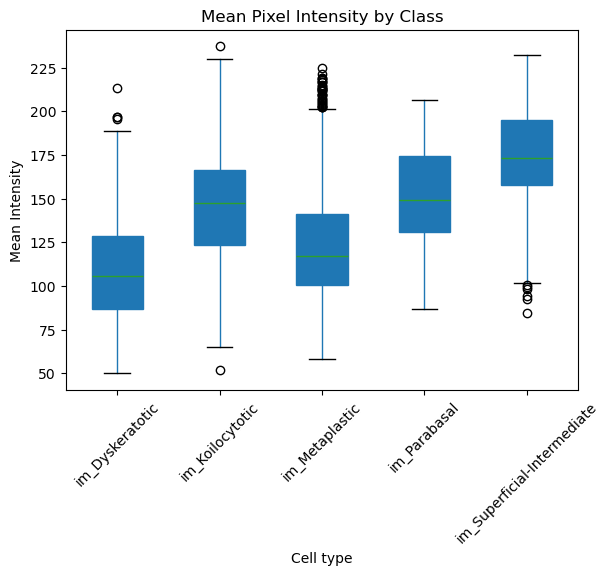

In [8]:
mean_intensities = features.mean(axis=1)

data = pd.DataFrame({"Class": labels, "Mean Intensity": mean_intensities})

data.boxplot(by="Class", column=["Mean Intensity"], grid=False, patch_artist=True)
plt.title("Mean Pixel Intensity by Class")
plt.suptitle("")
plt.xticks(rotation=45)
plt.xlabel("Cell type")
plt.ylabel("Mean Intensity")
plt.show()

In [9]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(features, y_encoded, test_size=0.2, random_state=None)

In [10]:
%%capture
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    "objective": "multiclass",
    "num_class": len(cell_types),
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "num_leaves": 50,
    "max_depth": 10,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "max_bin": 255,
    "verbosity": -1,
}

evals_result = {}

model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=100, callbacks=[lgb.callback.record_evaluation(evals_result)])

In [11]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = np.mean(y_pred_labels == y_test)

In [12]:
precision = precision_score(y_test, y_pred_labels, average="weighted")
recall = recall_score(y_test, y_pred_labels, average="weighted")
f1 = f1_score(y_test, y_pred_labels, average="weighted")

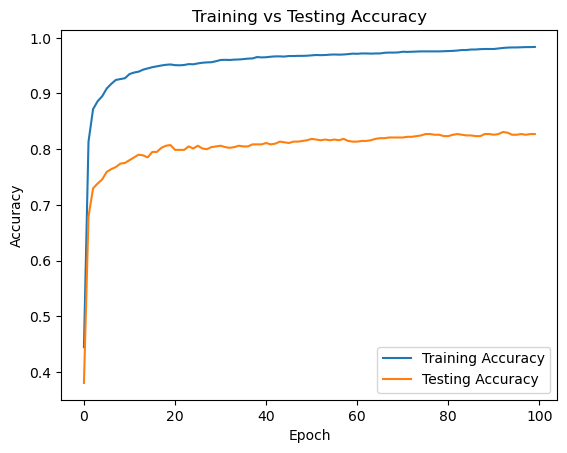

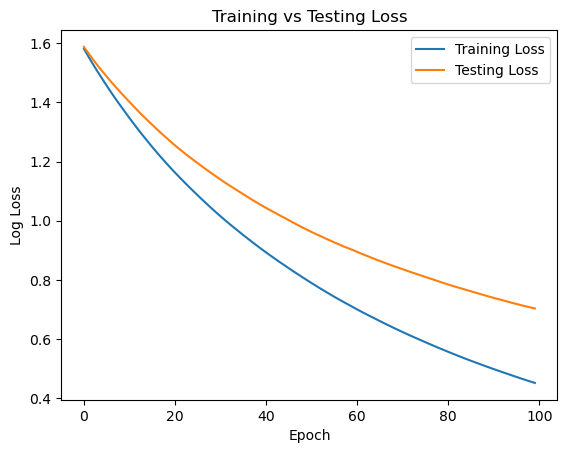

In [13]:
train_accuracy = [np.mean(np.argmax(model.predict(X_train, num_iteration=i+1), axis=1) == y_train) for i in range(100)]
test_accuracy = [np.mean(np.argmax(model.predict(X_test, num_iteration=i+1), axis=1) == y_test) for i in range(100)]

plt.plot(train_accuracy, label="Training Accuracy")
plt.plot(test_accuracy, label="Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Testing Accuracy")
plt.show()

plt.plot(evals_result["training"]["multi_logloss"], label="Training Loss")
plt.plot(evals_result["valid_1"]["multi_logloss"], label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.legend()
plt.title("Training vs Testing Loss")
plt.show()

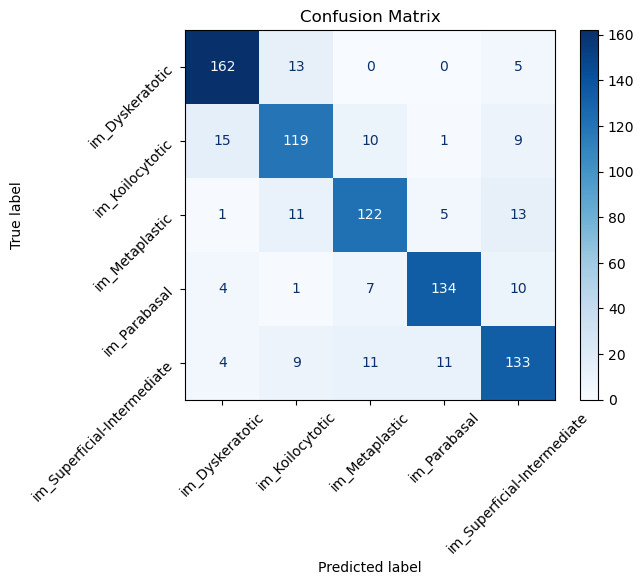

In [14]:
cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title("Confusion Matrix")
plt.show()

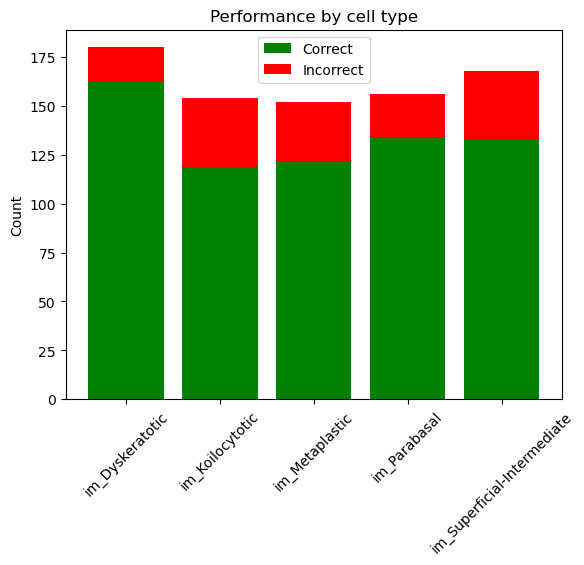

In [15]:
correct_per_class = np.zeros(len(cell_types))
incorrect_per_class = np.zeros(len(cell_types))

for i in range(len(cell_types)):
    correct_per_class[i] = np.sum((y_test == i) & (y_pred_labels == i))
    incorrect_per_class[i] = np.sum((y_test == i) & (y_pred_labels != i))

x = np.arange(len(cell_types))
plt.bar(x, correct_per_class, color="green", label="Correct")
plt.bar(x, incorrect_per_class, bottom=correct_per_class, color="red", label="Incorrect")
plt.xticks(x, cell_types, rotation=45)
plt.ylabel("Count")
plt.title("Performance by cell type")
plt.legend()
plt.show()

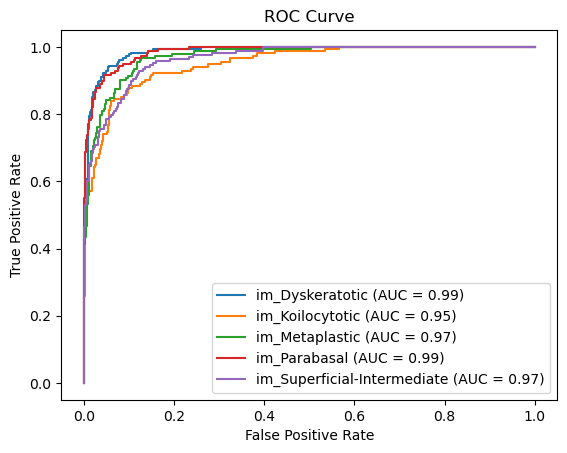

In [16]:
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc(fpr, tpr):.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [17]:
end_time = time.time()
total_time = end_time - start_time

In [18]:
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {evals_result["valid_1"]["multi_logloss"][-1]:.4f}")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1*100:.2f}%")
print(f"Computation Time: {total_time:.2f}s")

Test Accuracy: 82.72%
Test Loss: 0.7036
Precision: 82.72%
Recall: 82.72%
F1 Score: 82.71%
Computation Time: 849.81s
